In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## Load modules
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats

import os
import joblib
import pickle
import sys

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from joblib import dump


sys.path.append('/home/freimax/msc_thesis/scripts/plotting_functions/')
from plot_functions import plot_cross_section, draw_color_blocks, add_inset_plot
sys.path.append('/home/freimax/msc_thesis/scripts/random_forest/')
import rf_functions

In [3]:
## Load training data

def load_data(train_val='train'):
    assert isinstance(train_val, str) and train_val in ['train', 'val'], "train_val should be a string and must be either 'train' or 'val'"
    
    monthlist = ['DEC17','JAN18','FEB18','MAR18','APR18','MAY18','JUN18','JUL18','AUG18','SEP18','OCT18','NOV18']
    path = '/net/helium/atmosdyn/freimax/data_msc/IFS-18/cyclones/data_random_forest'

    list_df_1month = []
    for month in monthlist:
        list_df_1month.append(pd.read_pickle(f'{path}/{month}/df_ifs_masked_{train_val}.pkl'))

    # Concatenate all dataframes in the list into a single dataframe
    print('Concatente all df to one')
    df = pd.concat(list_df_1month, ignore_index=True)

    return df

df_train = load_data('train')
df_val = load_data('val')

Concatente all df to one
Concatente all df to one


In [4]:
## Drop unnecessary columns
df_train = df_train.drop(['tevr', 'RWC', 'tmeltsi'], axis=1)
df_val = df_val.drop(['tevr', 'RWC', 'tmeltsi'], axis=1)


In [5]:
print(df_train.shape)
print(df_val.shape)

(138658804, 6)
(14548323, 6)


In [6]:
df_tsubsi_train = rf_functions.apply_domainfilter(df=df_train,
                                                  water_type='SIWC',
                                                  scale_temp=False,
                                                  verbose=1,
                                                  temp_filter=False,
                                                  output_filter=False)

Drop all points where SIWC == 0
Filtered dataframe size:	5.53e+07 	39.9% of size compared to unfiltered. (Points dropped: 83384643)

	bcp_label was not part of dataframe, will create the labels now for following stats...

Class 0 fraction (before drop):	93.6%

Class Balance New Dataframe:
------------------------------
Class 0 fraction:	83.8%		46340315 Points
Class 1 fraction:	15.6%		8626129 Points
Class 2 fraction:	 0.6%		 307717 Points
------------------------------		--------------
Toatal points in new df:		55274161 Points




In [7]:
df_tsubsi_train

,CC,T,OMEGA,SIWC,tsubsi,RH_ifs
261,0.015625,2.381683,0.061454,0.003858,-0.049531,0.878177
299,0.078125,1.998627,0.080702,0.042146,-0.186958,0.898980
311,0.000000,1.807343,0.076540,0.015261,-0.083875,0.919767
330,0.000000,2.127655,0.030886,0.008523,-0.068184,0.828871
337,0.078125,1.662811,0.101443,0.078710,-0.222531,0.915377
...,...,...,...,...,...,...
138655184,0.000000,-61.373047,-0.004432,0.000201,-0.000009,0.325532
138655185,0.023438,-63.494629,-0.054969,0.000119,-0.000101,0.508201
138655204,0.101562,-66.574219,-0.072852,0.000387,-0.000061,0.819873
138655370,0.000000,-56.816528,-0.170075,0.000030,0.000002,0.095168


In [8]:
df_tsubsi_val = rf_functions.apply_domainfilter(df=df_val,
                                                water_type='SIWC',
                                                verbose=1,
                                                scale_temp=False,temp_filter=False,output_filter=False)

Drop all points where SIWC == 0
Filtered dataframe size:	6.02e+06 	41.4% of size compared to unfiltered. (Points dropped: 8524206)

	bcp_label was not part of dataframe, will create the labels now for following stats...

Class 0 fraction (before drop):	92.9%

Class Balance New Dataframe:
------------------------------
Class 0 fraction:	82.8%		4986945 Points
Class 1 fraction:	16.6%		1000411 Points
Class 2 fraction:	 0.6%		  36761 Points
------------------------------		--------------
Toatal points in new df:		6024117 Points




In [9]:
# Define the predictors and the target
target = 'tsubsi'

X_train = df_tsubsi_train.drop([target], axis=1)
y_train = df_tsubsi_train[target]

X_val = df_tsubsi_val.drop([target], axis=1)
y_val = df_tsubsi_val[target]

In [17]:
X_train

,CC,T,OMEGA,SIWC,RH_ifs
261,0.015625,2.381683,0.061454,0.003858,0.878177
299,0.078125,1.998627,0.080702,0.042146,0.898980
311,0.000000,1.807343,0.076540,0.015261,0.919767
330,0.000000,2.127655,0.030886,0.008523,0.828871
337,0.078125,1.662811,0.101443,0.078710,0.915377
...,...,...,...,...,...
138655184,0.000000,-61.373047,-0.004432,0.000201,0.325532
138655185,0.023438,-63.494629,-0.054969,0.000119,0.508201
138655204,0.101562,-66.574219,-0.072852,0.000387,0.819873
138655370,0.000000,-56.816528,-0.170075,0.000030,0.095168


In [10]:
assert X_train.shape[0] == y_train.shape[0]
assert X_val.shape[0] == y_val.shape[0]

In [11]:
def grid_search_with_validation_set(X_train, y_train, 
                                    X_val  , y_val  , 
                                    param_grid, 
                                    save_name):

    best_mse = np.inf
    best_params = None
    best_model = None

    total_iter = 1
    for key in param_grid.keys():
        total_iter *= len(param_grid[key])
    current_i = 0
    print('\nStart Grid-Search:')
    # Loop over the parameter grid
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for max_features in param_grid['max_features']:
                for min_samples_split in param_grid['min_samples_split']:
                    for min_samples_leaf in param_grid['min_samples_leaf']:
                        for criterion in param_grid['criterion']:
                            current_i +=1
                            # Create and train a Random Forest model
                            rf = RandomForestRegressor(n_estimators=n_estimators,
                                                        max_depth=max_depth,
                                                        max_features=max_features,
                                                        min_samples_split=min_samples_split,
                                                        min_samples_leaf=min_samples_leaf,
                                                        criterion=criterion,
                                                        n_jobs=35)
                            rf.fit(X_train, y_train)
                            # Predict the validation set results and compute the mean squared error
                            y_pred = rf.predict(X_val)
                            mse = mean_squared_error(y_val, y_pred)
                            # If this is the best model so far, save its parameters and score
                            if mse < best_mse:
                                best_mse = mse
                                best_params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'max_features': max_features, 'min_samples_split': min_samples_split}
                                best_model = rf

                                print(f'Model {current_i:3} of {total_iter:3} | n_estimators ={n_estimators:4} | max_depth = {max_depth} | max_features ={max_features:3} | min_samples_split ={min_samples_split:3}| min_samples_leaf ={min_samples_leaf:2} | criterion = {criterion} | RMSE: {np.sqrt(mse):.5f}  (NEW BEST)')
    
    print(f'\nBest parameters: {best_params}')
    print(f'Best MSE: {best_mse}  -->  Best RMSE: {np.sqrt(best_mse)}')

    dump(best_model, f'/net/helium/atmosdyn/freimax/data_msc/IFS-18/tsubsi/{save_name}.joblib')
    return best_model, best_params


In [12]:
filepath = f"/net/helium/atmosdyn/freimax/data_msc/IFS-18/tsubsi/first_try_tsubsi.joblib"

if os.path.isfile(filepath):
    print('Model exists')
else:
    doublecheck = input('Do you want to run the model?  (yes/no)')
    if doublecheck == 'yes':
        # Define the hyperparameters for grid search
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 30, ],
            'max_features': [3,5],
            'min_samples_split': [2,10]
        }


        # Call the function
        best_model, best_params = grid_search_with_validation_set(X_train=X_train,
                                                                y_train=y_train,
                                                                X_val=X_val,
                                                                y_val=y_val,
                                                                param_grid=param_grid,
                                                                save_name='rf_fulldata_gridsearch')


Model exists


In [13]:
# Load your trained model
best_model = joblib.load('/net/helium/atmosdyn/freimax/data_msc/IFS-18/tsubsi/first_try_tsubsi.joblib')

In [14]:
y_pred = best_model.predict(X_val)

Root Mean Squared Error (RMSE): 0.08364766897697395
R-squared: 0.6011693434160483


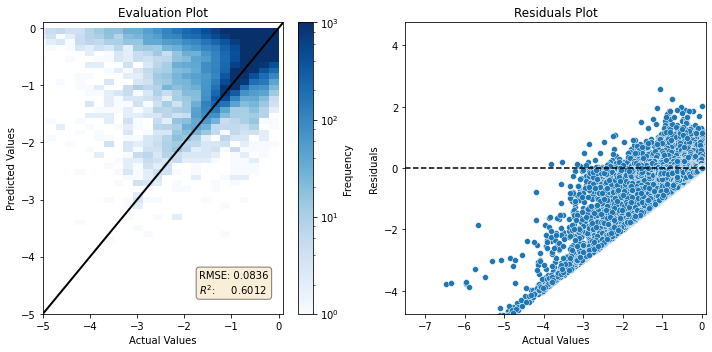

In [15]:
import matplotlib.colors as colors

residuals = y_val - y_pred

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

# Print out the metrics
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared:', r2)

# Create a scatter plot of actual vs predicted values
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# Scatter plot with hist2d
hist = ax[0].hist2d(y_val, y_pred, bins=40, cmap='Blues', norm=colors.LogNorm(vmax=1e3), )
ax[0].set_xlabel('Actual Values')
ax[0].set_ylabel('Predicted Values')
ax[0].set_title('Evaluation Plot')
ax[0].set_xlim(-5, 0.1)
ax[0].set_ylim(-5, 0.1)

ax[0].plot([-5,1], [-5,1], linewidth=2, c='k')
# Create a colorbar for the 2D histogram
cbar = plt.colorbar(hist[3], ax=ax[0])
cbar.set_label('Frequency')

# Set colorbar ticks to be logarithmic
cbar.ax.yaxis.set_major_locator(plt.LogLocator(base=10))
cbar.ax.yaxis.set_minor_locator(plt.LogLocator(base=10, subs=(0.2, 0.4, 0.6, 0.8)))

# Add text box with metrics
textstr = f'RMSE: {rmse:.4f}\n$R^2$:     {r2:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[0].text(0.65, 0.15, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

# Create a scatter plot of residuals
sns.scatterplot(x=y_val, y=residuals, ax=ax[1])
ax[1].set_xlabel('Actual Values')
ax[1].set_ylabel('Residuals')
ax[1].set_title('Residuals Plot')
ax[1].set_xlim(-7.5, 0.1)
ax[1].set_ylim(-4.75, 4.75)
ax[1].hlines(y=0, xmin=-7.5, xmax=0.1, linestyle='--', color='k')
plt.tight_layout()
plt.savefig(f'/net/helium/atmosdyn/freimax/figures/random_forest/IFS/tsubsi/grid_search_model_eval1_rmse_{rmse:.3f}.png',dpi=150)

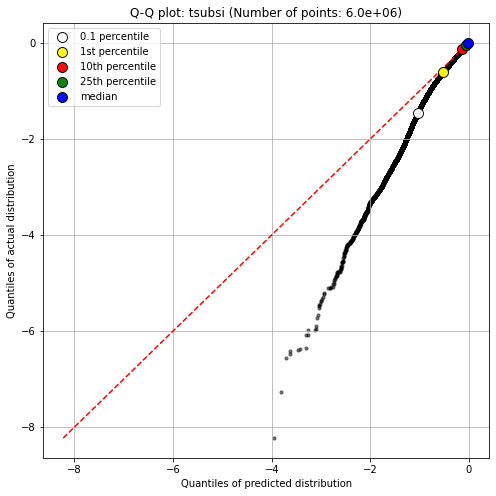

In [16]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


y_pred =y_pred

# Calculate the percentiles
y_pred_sorted = np.sort(y_pred)
y_val_sorted = np.sort(y_val)

# Generate percentiles
nr_points = len(y_pred)
percentiles = np.linspace(0, 100, nr_points ) 

# Calculate the Q-Q pairs
q_pred = np.percentile(y_pred_sorted, percentiles)
q_val = np.percentile(y_val_sorted, percentiles)
# Generate the plot
plt.figure(figsize=(8,8))
plt.scatter(q_pred, q_val, color='k', s=10, alpha=0.5)


# Mark median and other percentiles
p01_pred = np.percentile(q_pred, 0.1)
p01_val = np.percentile(q_val, 0.1)
plt.scatter(p01_pred, p01_val, color='white', edgecolor='k', label='0.1 percentile', s=100, zorder=5, alpha=0.95)

p1_pred = np.percentile(q_pred, 1)
p1_val = np.percentile(q_val, 1)
plt.scatter(p1_pred, p1_val, color='yellow', edgecolor='k', label='1st percentile', s=100, zorder=5, alpha=0.95)

p10_pred = np.percentile(q_pred, 10)
p10_val = np.percentile(q_val, 10)
plt.scatter(p10_pred, p10_val, color='red', edgecolor='k', label='10th percentile', s=100, zorder=5, alpha=0.95)

p25_pred = np.percentile(q_pred, 25)
p25_val = np.percentile(q_val, 25)
plt.scatter(p25_pred, p25_val, color='green', edgecolor='k', label='25th percentile', s=100, zorder=5, alpha=0.95)

median_pred = np.median(q_pred)
median_val = np.median(q_val)
plt.scatter(median_pred, median_val, color='blue', edgecolor='k', label='median', s=100, zorder=5, alpha=0.95)



# Diagonal line
plt.plot([np.min((q_pred.min(),q_val.min())), np.max((q_pred.max(),q_val.max()))], 
         [np.min((q_pred.min(),q_val.min())), np.max((q_pred.max(),q_val.max()))], 'r--')

plt.xlabel('Quantiles of predicted distribution')
plt.ylabel('Quantiles of actual distribution')
plt.title(f'Q-Q plot: tsubsi (Number of points: {nr_points:2.1e})')
plt.grid(True)
plt.legend() 
plt.show()


---
---
## Try Regression model after classification model

In [17]:
def apply_cooling_thr(X,y, thr):
    X_cutoff = X[y <= thr]
    y_cutoff = y[y <= thr]
    assert X_cutoff.shape[0] == y_cutoff.shape[0]
    print(f'New shape:\t{X_cutoff.shape }\nOld shape:\t{X.shape}')
    return X_cutoff, y_cutoff

In [18]:
tsubsi_thr = -0.001

print('Training Set')
X_train_cutoff, y_train_cutoff = apply_cooling_thr(X_train, y_train, tsubsi_thr)
print('Validation Set')
X_val_cutoff, y_val_cutoff = apply_cooling_thr(X_val, y_val, tsubsi_thr)

Training Set
New shape:	(36465512, 5)
Old shape:	(55274161, 5)
Validation Set
New shape:	(4007998, 5)
Old shape:	(6024117, 5)


In [23]:
# Define the hyperparameters for grid search
param_grid = {
    'n_estimators': [500],
    'max_depth': [30],
    'max_features': [3],
    'min_samples_split': [40],
    'min_samples_leaf':[1],
    'criterion': ['squared_error']
}

cutoff_models = []
cutoff_best_params = []
thr_list = [-1, -0.1, -0.01, -0.001, -0.0001, -0.00001]

for thr in thr_list:
    print(f'\n\nStart with model tsubsi cut-off at {thr}')
    print('Training Set:')
    X_train_cutoff, y_train_cutoff = apply_cooling_thr(X_train, y_train, thr)
    print('Validation Set')
    X_val_cutoff, y_val_cutoff = apply_cooling_thr(X_val, y_val, thr)
    # Call the function
    best_model, best_params = grid_search_with_validation_set(X_train=X_train_cutoff,
                                                                y_train=y_train_cutoff, 
                                                                X_val=X_val_cutoff, 
                                                                y_val=y_val_cutoff, 
                                                                param_grid=param_grid,
                                                                save_name=f'cutoff_{thr}_tsubsi'
                                                                )
    cutoff_models.append(best_model)
    cutoff_best_params.append(best_params)



Start with model tsubsi cut-off at -1
Training Set:
New shape:	(151673, 5)
Old shape:	(55274161, 5)
Validation Set
New shape:	(17549, 5)
Old shape:	(6024117, 5)

Start Grid-Search:
Model   1 of   1 | n_estimators = 500 | max_depth = 30 | max_features =  3 | min_samples_split = 40| min_samples_leaf = 1 | criterion = squared_error | RMSE: 0.51247  (NEW BEST)

Best parameters: {'n_estimators': 500, 'max_depth': 30, 'max_features': 3, 'min_samples_split': 40}
Best MSE: 0.262625468714412  -->  Best RMSE: 0.5124699685975872


Start with model tsubsi cut-off at -0.1
Training Set:
New shape:	(6981472, 5)
Old shape:	(55274161, 5)
Validation Set
New shape:	(814766, 5)
Old shape:	(6024117, 5)

Start Grid-Search:
Model   1 of   1 | n_estimators = 500 | max_depth = 30 | max_features =  3 | min_samples_split = 40| min_samples_leaf = 1 | criterion = squared_error | RMSE: 0.18525  (NEW BEST)

Best parameters: {'n_estimators': 500, 'max_depth': 30, 'max_features': 3, 'min_samples_split': 40}
Best MSE

In [24]:

cutoff_best_params

[{'n_estimators': 500,
  'max_depth': 30,
  'max_features': 3,
  'min_samples_split': 40},
 {'n_estimators': 500,
  'max_depth': 30,
  'max_features': 3,
  'min_samples_split': 40},
 {'n_estimators': 500,
  'max_depth': 30,
  'max_features': 3,
  'min_samples_split': 40},
 {'n_estimators': 500,
  'max_depth': 30,
  'max_features': 3,
  'min_samples_split': 40},
 {'n_estimators': 500,
  'max_depth': 30,
  'max_features': 3,
  'min_samples_split': 40},
 {'n_estimators': 500,
  'max_depth': 30,
  'max_features': 3,
  'min_samples_split': 40}]

Root Mean Squared Error (RMSE): 0.099
R-squared: 0.595


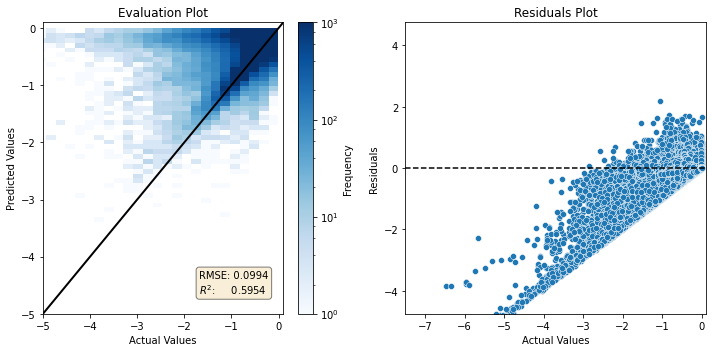

In [52]:
import matplotlib.colors as colors

residuals = y_val_cutoff - y_pred_cutoff

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_val_cutoff, y_pred_cutoff))
r2 = r2_score(y_val_cutoff, y_pred_cutoff)

# Print out the metrics
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
print(f'R-squared: {r2:.3f}')

# Create a scatter plot of actual vs predicted values
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# Scatter plot with hist2d
hist = ax[0].hist2d(y_val_cutoff, y_pred_cutoff, bins=40, cmap='Blues', norm=colors.LogNorm(vmax=1e3), )
ax[0].set_xlabel('Actual Values')
ax[0].set_ylabel('Predicted Values')
ax[0].set_title('Evaluation Plot')
ax[0].set_xlim(-5, 0.1)
ax[0].set_ylim(-5, 0.1)

ax[0].plot([-5,1], [-5,1], linewidth=2, c='k')
# Create a colorbar for the 2D histogram
cbar = plt.colorbar(hist[3], ax=ax[0])
cbar.set_label('Frequency')

# Set colorbar ticks to be logarithmic
cbar.ax.yaxis.set_major_locator(plt.LogLocator(base=10))
cbar.ax.yaxis.set_minor_locator(plt.LogLocator(base=10, subs=(0.2, 0.4, 0.6, 0.8)))

# Add text box with metrics
textstr = f'RMSE: {rmse:.4f}\n$R^2$:     {r2:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[0].text(0.65, 0.15, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

# Create a scatter plot of residuals
sns.scatterplot(x=y_val_cutoff, y=residuals, ax=ax[1])
ax[1].set_xlabel('Actual Values')
ax[1].set_ylabel('Residuals')
ax[1].set_title('Residuals (y_pred - y)')
ax[1].set_xlim(-7.5, 0.1)
ax[1].set_ylim(-4.75, 4.75)
ax[1].hlines(y=0, xmin=-7.5, xmax=0.1, linestyle='--', color='k')
plt.tight_layout()
plt.savefig(f'/home/freimax/msc_thesis/figures/random_forest/IFS/tsubsi/grid_search_model_cutoff_rmse_{rmse:.3f}.png',dpi=150)

---
### Test accuracy of baseline model with threshold cut-oofs

In [74]:
X_val_cutoff1, y_val_cutoff1 = apply_cooling_thr(X_val, y_val, -0.1)

New shape:	(814766, 5)
Old shape:	(6024117, 5)


In [75]:
y_pred_cutoff1 = best_model.predict(X_val_cutoff1)
y_pred_full = best_model.predict(X_val)

In [76]:
y_val_foo  = y_val[y_val<=-0.1]              ## Note, this is the same as y_val_cutoff1
y_pred_foo = y_pred_full[y_val<=-0.1]


In [91]:
print(f'Full data preds: {y_pred_full.shape}')
print(f'Cutoff data preds: {y_pred_cutoff1.shape}')

Full data preds: (6024117,)
Cutoff data preds: (814766,)


In [92]:
## Check if arryas are allclose
if np.allclose(y_pred_cutoff1, y_pred_foo):
    print('Arrays are allclose')

Arrays are allclose


In [28]:
y_preds_cutoff = [] 
y_val_cutoff = []
rmse_cutoffs = []
r2_cutoffs = []

thr_list = [-1, -0.1, -0.01, -0.001, -0.0001, -0.00001]
for i, thr in enumerate(thr_list):
    print(f'Predict and evaluate model with threshold: {thr}:')
    X_val_cutoff, y_validation_cutoff = apply_cooling_thr(X_val, y_val, thr)
    
    y_val_cutoff.append(y_validation_cutoff)
    
    y_pred_cutoff = cutoff_models[i].predict(X_val_cutoff)
    y_preds_cutoff.append(y_pred_cutoff)

    rmse_cutoffs.append( np.sqrt(mean_squared_error(y_validation_cutoff, y_pred_cutoff)))
    r2_cutoffs.append(r2_score(y_validation_cutoff, y_pred_cutoff))


Predict and evaluate model with threshold: -1:
New shape:	(17549, 5)
Old shape:	(6024117, 5)
Predict and evaluate model with threshold: -0.1:
New shape:	(814766, 5)
Old shape:	(6024117, 5)
Predict and evaluate model with threshold: -0.01:
New shape:	(2741518, 5)
Old shape:	(6024117, 5)
Predict and evaluate model with threshold: -0.001:
New shape:	(4007998, 5)
Old shape:	(6024117, 5)
Predict and evaluate model with threshold: -0.0001:
New shape:	(4854206, 5)
Old shape:	(6024117, 5)
Predict and evaluate model with threshold: -1e-05:
New shape:	(5420201, 5)
Old shape:	(6024117, 5)


In [41]:
preds_cutof_on_fulldata = []
rmse_co_fulldata = []
r2_co_fulldata = []


color_list = ['#000000', '#404040', '#808080', '#C0C0C0', '#FFFFFF']
for i, thr in enumerate(thr_list):
    print(f'Prediction with cut-off model at {thr}')
    pred = cutoff_models[i].predict(X_val)
    
    preds_cutof_on_fulldata.append(pred)
    rmse_co_fulldata.append( np.sqrt(mean_squared_error(y_val, pred)) )
    r2_co_fulldata.append( r2_score(y_val, pred) )

Prediction with cut-off model at -1
Prediction with cut-off model at -0.1
Prediction with cut-off model at -0.01
Prediction with cut-off model at -0.001
Prediction with cut-off model at -0.0001
Prediction with cut-off model at -1e-05


In [34]:
threshold_list = np.arange(-0.00001,-1.1, -0.001)#[-0.1, -0.01, -0.005, -0.001, -0.0001]

rmse_list =[]
r2_list = []

for i,thr in enumerate(threshold_list):
    y_val_cutoff = y_val[y_val<=thr] 
    y_pred_cutoff = y_pred[y_val<=thr]

    rmse_list.append(np.sqrt(mean_squared_error(y_val_cutoff, y_pred_cutoff)))
    r2_list.append(r2_score(y_val_cutoff, y_pred_cutoff))
    
    if (i+1) % 100 == 0:
        print(f'Done with step {i+1} of {threshold_list.shape[0]}')
    

Done with step 100 of 1100
Done with step 200 of 1100
Done with step 300 of 1100
Done with step 400 of 1100
Done with step 500 of 1100
Done with step 600 of 1100
Done with step 700 of 1100
Done with step 800 of 1100
Done with step 900 of 1100
Done with step 1000 of 1100
Done with step 1100 of 1100


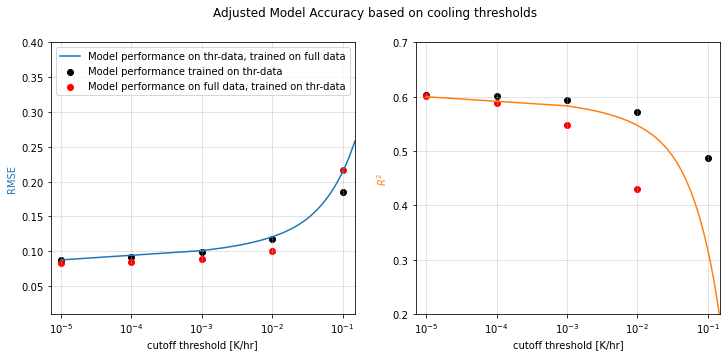

In [55]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.suptitle('Adjusted Model Accuracy based on cooling thresholds', fontsize=12)

ax[0].plot(-threshold_list, rmse_list, c='#1f77b4', label='Model performance on thr-data, trained on full data')
#ax[0].invert_xaxis()
ax[0].set_xlabel('cutoff threshold [K/hr]')
ax[0].set_ylabel('RMSE', c='#1f77b4', fontsize=10)
# ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylim(0.01, 0.4)
ax[0].set_xlim(7.1e-6, 0.15)

ax[1].plot(-threshold_list, r2_list, c='#ff7f0e')
#ax[1].invert_xaxis()
ax[1].set_ylabel(r'$R^2$', c='#ff7f0e', fontsize=10)
ax[1].set_xlabel('cutoff threshold [K/hr]')
ax[1].set_xscale('log')
ax[1].set_xlim(7.1e-6, 0.15)
ax[1].set_ylim(0.2, 0.7)

ax[0].scatter([-x for x in thr_list], rmse_cutoffs, c='k', label='Model performance trained on thr-data')
ax[1].scatter([-x for x in thr_list], r2_cutoffs, c='k')

ax[0].scatter([-x for x in thr_list], rmse_co_fulldata, c='red', label='Model performance on full data, trained on thr-data')
ax[1].scatter([-x for x in thr_list], r2_co_fulldata, c='red')

ax[0].legend()

# Adding grid lines
for axes in ax:
    if axes.get_xscale() == 'log':
        axes.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
        axes.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
        axes.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, numticks=150))
    else:
        axes.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

plt.show()